In [ ]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install matplotlib
!pip install sklearn

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

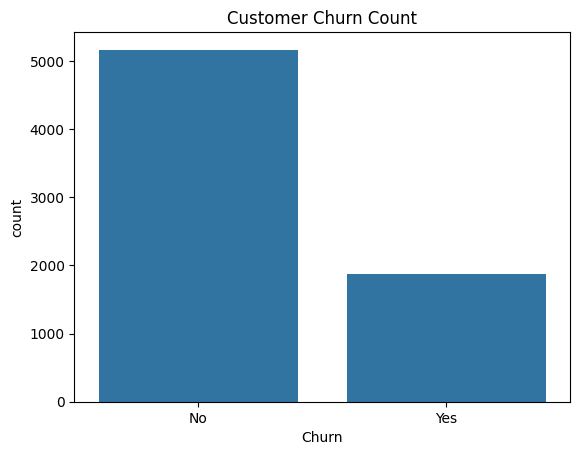

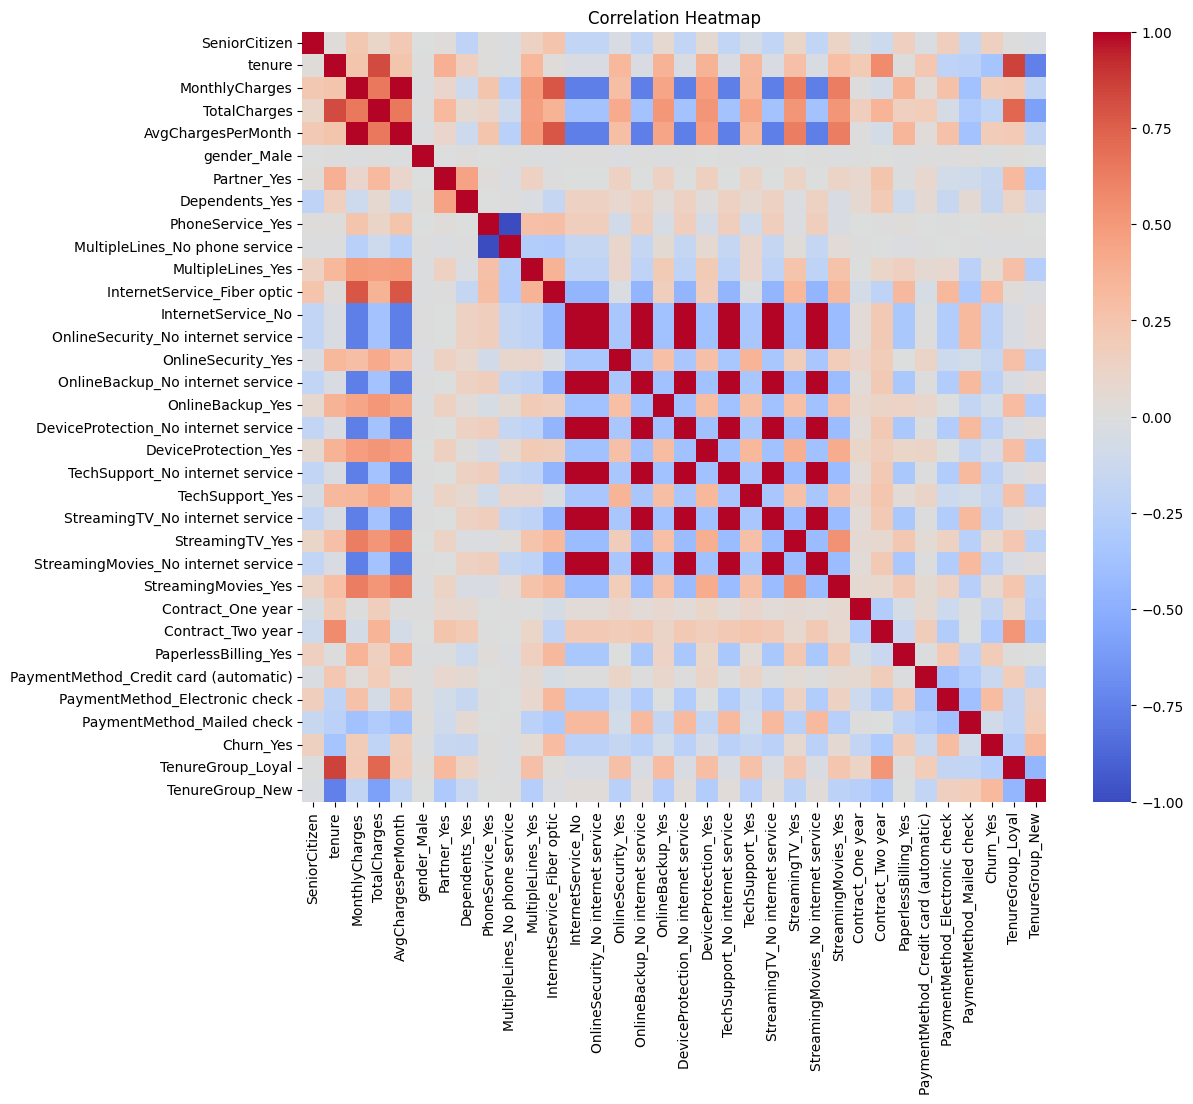

=== Logistic Regression ===
Accuracy: 0.795734597156398

Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.90      0.87      1549
        True       0.65      0.51      0.57       561

    accuracy                           0.80      2110
   macro avg       0.74      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110


Confusion Matrix:
 [[1393  156]
 [ 275  286]]

AUC Score: 0.8369104787287295


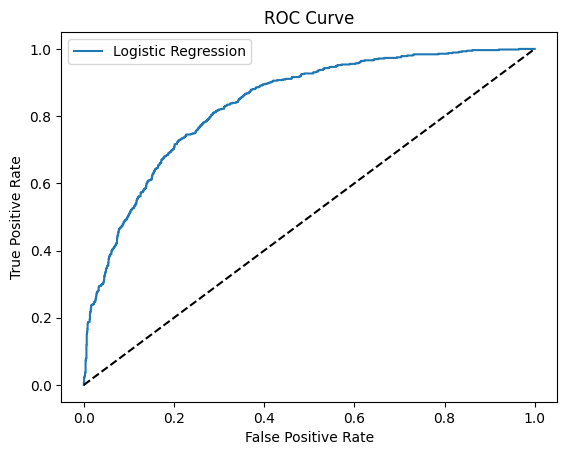


=== Random Forest ===
Accuracy: 0.7843601895734598

Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.90      0.86      1549
        True       0.62      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110


Confusion Matrix:
 [[1388  161]
 [ 294  267]]

AUC Score: 0.8203930084270342


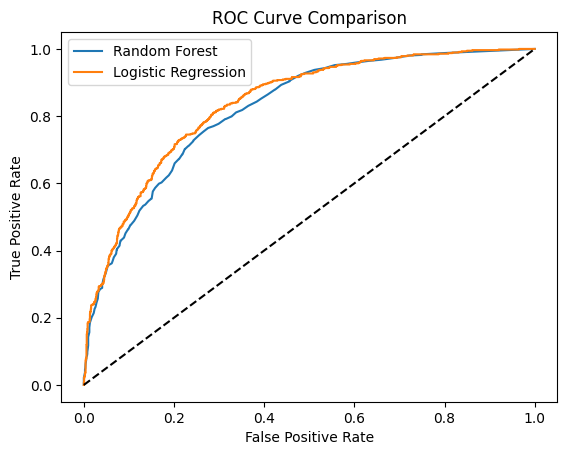

In [2]:

# TELCO CUSTOMER CHURN PREDICTION PROJECT

# 1 IMPORT LIBRARIES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)


# 2 LOAD DATA

df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())


# 3 CLEAN DATA

# Convert 'TotalCharges' to numeric and drop rows with missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Drop 'customerID' — not useful for prediction
df.drop('customerID', axis=1, inplace=True)

# 4 Categorize tenure into groups

def tenure_group(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 48:
        return 'Intermediate'
    else:
        return 'Loyal'

df['TenureGroup'] = df['tenure'].apply(tenure_group)

# Average Charges Per Month
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure']


# 5 ENCODE CATEGORICAL VARIABLES

df_encoded = pd.get_dummies(df, drop_first=True)
print("\n Encoded columns:", df_encoded.columns)


# 6 EXPLORATORY DATA ANALYSIS (EDA)

# Churn Count Plot
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Count')
plt.show()

# Correlation Heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 7 SPLIT DATA INTO FEATURES & TARGET

X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 8 LOGISTIC REGRESSION WITH PIPELINE

# Use Pipeline to ensure scaling is done properly

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Train

pipeline.fit(X_train, y_train)

# Predict

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


# 9 EVALUATE LOGISTIC REGRESSION

print("\n=== Logistic Regression Results ===")
print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\n AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# 10 RANDOM FOREST CLASSIFIER FOR BENCHMARK

# Train Random Forest for comparison
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n=== Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"\n AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Plot ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


#  BUSINESS INTERPRETATION:
# - Dataset churn rate ~26%
# - Improving prediction by just 10% can help retain ~26,000 more customers per million
# - Assuming ARPU $50/month -> saving over $15M annually
# - Shows how feature engineering and ML directly support cost savings
